# ISP-GIN Real-Valued Ablation & Interference Isolation Experiment

This notebook demonstrates an ablation experiment that isolates the contribution of **complex-valued interference** in the ISP-GIN graph distinguishability framework.

**What it does:**
- Implements 5 graph representation methods: ISP-GIN (complex), RealGIN-Aug (real-valued), ISP-NoMP magnitude, ISP-NoMP phases, and 1-WL baseline
- Tests each method's ability to distinguish non-isomorphic graph pairs that are 1-WL equivalent
- Runs a random walk t-sweep and extended frequency sweep
- Compares results across 4 datasets (BREC basic, regular, CFI, and CSL)

**Key finding:** RealGIN-Aug (real-valued) strictly outperforms ISP-GIN (complex-valued), with the gap entirely from CSL graphs where ISP-GIN fails all pairs. Complex interference adds no expressiveness over real-valued features with real message passing.

**Method:** Pure numpy/networkx computation — no neural network training needed.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# loguru — NOT pre-installed on Colab, always install
_pip('loguru==0.7.3')

# numpy, networkx, matplotlib — pre-installed on Colab, install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'networkx==3.6.1', 'matplotlib==3.10.0', 'scipy==1.16.3')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import sys
import time

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger

# Logging setup (notebook-friendly)
logger.remove()
logger.add(sys.stdout, level="INFO", format="{time:HH:mm:ss}|{level:<7}|{message}")

1

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-1a90b0-interference-based-structural-probing-br/main/experiment_iter3_isp_gin_real_va/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

import os

In [4]:
data = load_data()

total_examples = sum(len(ds["examples"]) for ds in data["datasets"])
n_datasets = len(data["datasets"])
logger.info(f"Loaded {total_examples} examples across {n_datasets} datasets")
for ds in data["datasets"]:
    logger.info(f"  {ds['dataset']}: {len(ds['examples'])} pairs")

22:29:53|INFO   |Loaded 12 examples across 4 datasets


22:29:53|INFO   |  brec_basic: 3 pairs


22:29:53|INFO   |  brec_regular: 3 pairs


22:29:53|INFO   |  brec_cfi: 3 pairs


22:29:53|INFO   |  csl: 3 pairs


## Configuration

All tunable parameters for the experiment. Adjust these to trade off between runtime and thoroughness.

In [5]:
# ---------------------------------------------------------------------------
# Experiment configuration — all tunable parameters
# ---------------------------------------------------------------------------

# Epsilon thresholds for distinguishability testing
EPSILON_THRESHOLDS = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2]  # original: [1e-10, 1e-8, 1e-6, 1e-4, 1e-2]
PRIMARY_EPSILON = 1e-6  # original: 1e-6

# ISP-GIN frequency channels
K_DEFAULT = 8  # original: 8

# Message passing layers to sweep
L_VALUES = [1, 2, 3, 4]  # original: [1, 2, 3, 4]

# Random walk return probability time steps
RW_T_VALUES = [2, 3, 4, 5, 6]  # original: [2, 3, 4, 5, 6]

# WL color refinement iterations
WL_ITERATIONS = 5  # original: 5

# Max examples to process (None = all)
MAX_EXAMPLES = None  # original: None

## Graph Construction

Parse JSON graph pair data into NetworkX graph objects.

In [6]:
def build_graph_from_example(example: dict) -> tuple:
    """Parse 'input' JSON string into two networkx graphs."""
    input_data = json.loads(example["input"])

    ga = input_data["graph_a"]
    gb = input_data["graph_b"]

    G1 = nx.Graph()
    G1.add_nodes_from(range(ga["num_nodes"]))
    G1.add_edges_from(ga["edge_list"])

    G2 = nx.Graph()
    G2.add_nodes_from(range(gb["num_nodes"]))
    G2.add_edges_from(gb["edge_list"])

    return G1, G2

## Node Feature Computation

Compute topological node features: degree, clustering coefficient, neighbor degree variance, and random walk return probabilities for t=2..6.

In [7]:
def compute_node_features(G: nx.Graph) -> dict:
    """Compute topological node features for a graph.

    Features: degree, clustering coefficient, neighbor degree variance,
    and random walk return probabilities for t=2..6.
    """
    n = G.number_of_nodes()
    features = {}

    # 1. Degree
    degrees = np.array([G.degree(v) for v in range(n)], dtype=np.float64)
    features["degree"] = degrees

    # 2. Clustering coefficient
    cc = nx.clustering(G)
    features["clustering_coeff"] = np.array(
        [cc[v] for v in range(n)], dtype=np.float64
    )

    # 3. Neighbor degree variance
    ndv = np.zeros(n, dtype=np.float64)
    for v in range(n):
        if G.degree(v) > 0:
            neighbor_degs = [G.degree(u) for u in G.neighbors(v)]
            ndv[v] = np.var(neighbor_degs)
    features["neighbor_deg_var"] = ndv

    # 4. Random walk return probabilities for t=2..6
    A = nx.adjacency_matrix(G).toarray().astype(np.float64)
    deg_safe = np.maximum(degrees, 1.0)
    D_inv = np.diag(1.0 / deg_safe)
    P = D_inv @ A  # transition matrix

    for t in RW_T_VALUES:
        P_t = np.linalg.matrix_power(P, t)
        features[f"rw_return_t{t}"] = np.diag(P_t)

    return features

## Method Implementations

Five graph representation methods:
1. **ISP-GIN** — Complex-valued message passing with harmonic initialization
2. **RealGIN-Aug** — Real-valued GIN with augmented topological features (no complex arithmetic)
3. **ISP-NoMP (magnitude)** — ISP initialization only, no message passing (expected: all-ones)
4. **ISP-NoMP (phases)** — ISP initialization phases only, no message passing
5. **1-WL** — Standard Weisfeiler-Leman color refinement baseline

In [8]:
def _get_init_features(features: dict, init_type: str) -> np.ndarray:
    """Get the scalar node feature vector f(v) for ISP initialization."""
    if init_type == "local_topology":
        cc = features["clustering_coeff"]
        ndv = features["neighbor_deg_var"]
        deg = features["degree"]
        ndv_max = np.max(ndv) + 1e-10
        deg_max = np.max(deg) + 1e-10
        return cc + ndv / ndv_max + deg / deg_max

    if init_type.startswith("random_walk_t"):
        t = int(init_type.split("t")[1])
        key = f"rw_return_t{t}"
        if key not in features:
            raise ValueError(f"Feature {key} not computed (t={t})")
        return features[key]

    raise ValueError(f"Unknown init_type: {init_type}")


def isp_gin(G, features, init_type, K=K_DEFAULT, L=3, epsilon=0.0):
    """ISP-GIN: Complex-valued message passing with harmonic initialization.

    For each frequency channel k=1..K:
      1. Initialize: z_v^(0) = exp(i * omega_k * f(v))
      2. For l=1..L: z_v^(l) = (1+eps)*z_v^(l-1) + sum_{u in N(v)} z_u^(l-1)
      3. Extract: magnitude |z_v^(L)|

    Graph representation = sorted magnitudes concatenated across K channels.
    """
    n = G.number_of_nodes()
    A = nx.adjacency_matrix(G).toarray().astype(np.float64)
    f_v = _get_init_features(features, init_type)

    omegas = np.logspace(-1, 2, K)

    graph_repr = []
    for omega in omegas:
        z = np.exp(1j * omega * f_v)  # complex128

        for _ in range(L):
            z = (1 + epsilon) * z + A @ z

        magnitudes = np.abs(z)
        graph_repr.append(np.sort(magnitudes))

    return np.concatenate(graph_repr)


def real_gin_aug(G, features, feature_keys, L=3, epsilon=0.0):
    """Real-valued GIN with augmented topological features. NO complex arithmetic.

    For each node: x_v^(0) = [f1(v), f2(v), ..., fD(v)]
    For l=1..L: x_v^(l) = (1+eps)*x_v^(l-1) + sum_{u in N(v)} x_u^(l-1)
    Graph repr = sorted node features concatenated (lexicographic sort on rows).
    """
    n = G.number_of_nodes()
    A = nx.adjacency_matrix(G).toarray().astype(np.float64)

    X = np.column_stack([features[k] for k in feature_keys])  # (n, D)

    for _ in range(L):
        X = (1 + epsilon) * X + A @ X

    sort_idx = np.lexsort(X.T[::-1])
    return X[sort_idx].flatten()


def isp_no_mp(G, features, init_type, K=K_DEFAULT):
    """ISP initialization only — NO message passing.

    z_v = exp(i * omega * f(v)), extract |z_v| immediately.
    NOTE: |exp(i*theta)| = 1 always, so this produces all-ones vectors.
    This is EXPECTED and proves MP is necessary for interference.
    """
    n = G.number_of_nodes()
    f_v = _get_init_features(features, init_type)
    omegas = np.logspace(-1, 2, K)

    graph_repr = []
    for omega in omegas:
        z = np.exp(1j * omega * f_v)
        magnitudes = np.abs(z)  # all 1.0 by construction
        graph_repr.append(np.sort(magnitudes))

    return np.concatenate(graph_repr)


def isp_no_mp_phases(G, features, init_type, K=K_DEFAULT):
    """ISP-NoMP using sorted phases instead of magnitudes.

    phases = omega * f(v) mod 2pi, sorted.
    This reduces to: can sorted node features alone distinguish graphs?
    """
    n = G.number_of_nodes()
    f_v = _get_init_features(features, init_type)
    omegas = np.logspace(-1, 2, K)

    graph_repr = []
    for omega in omegas:
        phases = np.angle(np.exp(1j * omega * f_v))  # in [-pi, pi]
        graph_repr.append(np.sort(phases))

    return np.concatenate(graph_repr)


def wl_hash(G, iterations=WL_ITERATIONS):
    """Standard 1-WL color refinement. Returns canonical hash string."""
    n = G.number_of_nodes()
    colors = {v: str(G.degree(v)) for v in range(n)}

    for _ in range(iterations):
        new_colors = {}
        for v in range(n):
            neighbor_colors = sorted([colors[u] for u in G.neighbors(v)])
            new_colors[v] = str(hash((colors[v], tuple(neighbor_colors))))
        colors = new_colors

    return str(sorted(colors.values()))

## Distinguishability Testing & Aggregate Helpers

Two graph representations are "distinguished" if their L-infinity distance exceeds epsilon.

In [9]:
def are_distinguished(repr1, repr2, epsilon=PRIMARY_EPSILON):
    """Two graphs are distinguished if their representations differ.
    Uses L-infinity norm (max absolute difference) > epsilon.
    """
    if repr1.shape != repr2.shape:
        return True
    return float(np.max(np.abs(repr1 - repr2))) > epsilon


def _eps_to_safe_key(eps: float) -> str:
    """Convert epsilon to schema-safe key (no dots or minus signs)."""
    s = f"{eps:.0e}"
    return s.replace("-", "m").replace("+", "p").replace(".", "p")


def are_distinguished_all_eps(repr1, repr2):
    """Test distinguishability at all epsilon thresholds."""
    results = {}
    if repr1.shape != repr2.shape:
        for eps in EPSILON_THRESHOLDS:
            results[f"eps_{_eps_to_safe_key(eps)}"] = True
        return results

    diff = float(np.max(np.abs(repr1 - repr2)))
    for eps in EPSILON_THRESHOLDS:
        results[f"eps_{_eps_to_safe_key(eps)}"] = diff > eps
    return results


def _update_agg(agg, per_dataset_agg, ds_name, method_key, dist):
    """Update aggregate counters."""
    if method_key not in agg:
        agg[method_key] = {"distinguished": 0, "total": 0}
    agg[method_key]["total"] += 1
    if dist == "distinguished":
        agg[method_key]["distinguished"] += 1

    if method_key not in per_dataset_agg[ds_name]:
        per_dataset_agg[ds_name][method_key] = {"distinguished": 0, "total": 0}
    per_dataset_agg[ds_name][method_key]["total"] += 1
    if dist == "distinguished":
        per_dataset_agg[ds_name][method_key]["distinguished"] += 1

## Main Experiment Loop

Process all graph pairs across all methods. For each pair: compute features, run all 5 methods with various configurations, record which pairs are distinguished.

In [10]:
def _build_metadata(agg, per_dataset_agg, total_processed):
    """Build metadata dict with aggregate results."""
    aggregate_results = {}
    for method, counts in sorted(agg.items()):
        d = counts["distinguished"]
        t = counts["total"]
        aggregate_results[method] = {
            "distinguished": d,
            "total": t,
            "fraction": round(d / t, 4) if t > 0 else 0.0,
        }

    # Interference contribution analysis
    interference = {}
    for L in L_VALUES:
        isp_key = f"isp_gin_random_walk_t3_L{L}"
        real_key = f"real_gin_aug_L{L}"
        if isp_key in agg and real_key in agg:
            isp_d = agg[isp_key]["distinguished"]
            real_d = agg[real_key]["distinguished"]
            total = agg[isp_key]["total"]
            interference[f"isp_vs_real_rw_t3_L{L}"] = (
                f"{isp_d} vs {real_d} out of {total} "
                f"(ISP: {isp_d}/{total}, Real: {real_d}/{total})"
            )

    # RW sweep summary
    rw_sweep = {}
    for t in RW_T_VALUES:
        key = f"isp_gin_rw_t{t}_L3"
        if key in agg:
            d = agg[key]["distinguished"]
            total = agg[key]["total"]
            rw_sweep[f"t{t}"] = f"{d}/{total}"

    per_ds_summary = {}
    for ds_name, methods in per_dataset_agg.items():
        ds_summary = {}
        for method, counts in sorted(methods.items()):
            d = counts["distinguished"]
            t = counts["total"]
            ds_summary[method] = f"{d}/{t}"
        per_ds_summary[ds_name] = ds_summary

    return {
        "description": "ISP-GIN ablation study: isolating complex interference contribution",
        "total_pairs_processed": total_processed,
        "primary_epsilon": PRIMARY_EPSILON,
        "aggregate_results": aggregate_results,
        "interference_contribution": interference,
        "rw_sweep": rw_sweep,
        "per_dataset_breakdown": per_ds_summary,
    }


def run_experiment(data, max_examples=None):
    """Main experiment: process all pairs across all methods."""
    results_by_dataset = []
    agg = {}
    per_dataset_agg = {}
    total_processed = 0

    for ds_entry in data["datasets"]:
        ds_name = ds_entry["dataset"]
        examples_out = []
        per_dataset_agg[ds_name] = {}

        examples = ds_entry["examples"]
        if max_examples is not None:
            remaining = max_examples - total_processed
            if remaining <= 0:
                break
            examples = examples[:remaining]

        logger.info(f"Processing dataset '{ds_name}': {len(examples)} pairs")

        for ex_idx, example in enumerate(examples):
            try:
                G1, G2 = build_graph_from_example(example)
                feats1 = compute_node_features(G1)
                feats2 = compute_node_features(G2)

                result = {
                    "metadata_pair_id": example.get("metadata_pair_id", ""),
                    "metadata_dataset": ds_name,
                    "metadata_num_nodes_g1": G1.number_of_nodes(),
                    "metadata_num_nodes_g2": G2.number_of_nodes(),
                }

                # --- WL baseline ---
                wl1, wl2 = wl_hash(G1), wl_hash(G2)
                wl_dist = "distinguished" if wl1 != wl2 else "not_distinguished"
                result["predict_wl_baseline"] = wl_dist
                _update_agg(agg, per_dataset_agg, ds_name, "wl_baseline", wl_dist)

                # --- ISP-GIN variants ---
                for init in ["random_walk_t3", "local_topology"]:
                    for L in L_VALUES:
                        r1 = isp_gin(G1, feats1, init, K=K_DEFAULT, L=L)
                        r2 = isp_gin(G2, feats2, init, K=K_DEFAULT, L=L)
                        dist = "distinguished" if are_distinguished(r1, r2) else "not_distinguished"
                        key = f"isp_gin_{init}_L{L}"
                        result[f"predict_{key}"] = dist
                        _update_agg(agg, per_dataset_agg, ds_name, key, dist)

                # --- RealGIN-Aug ---
                feature_keys_all = [
                    "clustering_coeff", "neighbor_deg_var", "rw_return_t3", "degree",
                ]
                for L in L_VALUES:
                    r1 = real_gin_aug(G1, feats1, feature_keys_all, L=L)
                    r2 = real_gin_aug(G2, feats2, feature_keys_all, L=L)
                    dist = "distinguished" if are_distinguished(r1, r2) else "not_distinguished"
                    key = f"real_gin_aug_L{L}"
                    result[f"predict_{key}"] = dist
                    _update_agg(agg, per_dataset_agg, ds_name, key, dist)

                # --- ISP-NoMP (magnitude) ---
                for init in ["random_walk_t3", "local_topology"]:
                    r1 = isp_no_mp(G1, feats1, init, K=K_DEFAULT)
                    r2 = isp_no_mp(G2, feats2, init, K=K_DEFAULT)
                    dist = "distinguished" if are_distinguished(r1, r2) else "not_distinguished"
                    key = f"isp_nomp_mag_{init}"
                    result[f"predict_{key}"] = dist
                    _update_agg(agg, per_dataset_agg, ds_name, key, dist)

                # --- ISP-NoMP (phases) ---
                for init in ["random_walk_t3", "local_topology"]:
                    r1 = isp_no_mp_phases(G1, feats1, init, K=K_DEFAULT)
                    r2 = isp_no_mp_phases(G2, feats2, init, K=K_DEFAULT)
                    dist = "distinguished" if are_distinguished(r1, r2) else "not_distinguished"
                    key = f"isp_nomp_phase_{init}"
                    result[f"predict_{key}"] = dist
                    _update_agg(agg, per_dataset_agg, ds_name, key, dist)

                # --- RW t-sweep for ISP-GIN (L=3 fixed) ---
                for t in RW_T_VALUES:
                    r1 = isp_gin(G1, feats1, f"random_walk_t{t}", K=K_DEFAULT, L=3)
                    r2 = isp_gin(G2, feats2, f"random_walk_t{t}", K=K_DEFAULT, L=3)
                    dist = "distinguished" if are_distinguished(r1, r2) else "not_distinguished"
                    key = f"isp_gin_rw_t{t}_L3"
                    result[f"predict_{key}"] = dist
                    _update_agg(agg, per_dataset_agg, ds_name, key, dist)

                # --- ISP-GIN extended frequency (K=16) ---
                r1 = isp_gin(G1, feats1, "random_walk_t3", K=16, L=3)
                r2 = isp_gin(G2, feats2, "random_walk_t3", K=16, L=3)
                dist = "distinguished" if are_distinguished(r1, r2) else "not_distinguished"
                key = "isp_gin_rw_t3_K16_L3"
                result[f"predict_{key}"] = dist
                _update_agg(agg, per_dataset_agg, ds_name, key, dist)

                # --- Epsilon robustness for ISP-GIN rw_t3 L3 ---
                r1_ref = isp_gin(G1, feats1, "random_walk_t3", K=K_DEFAULT, L=3)
                r2_ref = isp_gin(G2, feats2, "random_walk_t3", K=K_DEFAULT, L=3)
                eps_results = are_distinguished_all_eps(r1_ref, r2_ref)
                for eps_key, eps_val in eps_results.items():
                    result[f"metadata_isp_gin_rw_t3_L3_{eps_key}"] = str(eps_val)

                examples_out.append(result)
                total_processed += 1

            except Exception as e:
                logger.exception(f"Failed on pair {ex_idx} in dataset {ds_name}")
                continue

        results_by_dataset.append({
            "dataset": ds_name,
            "examples": examples_out,
        })

    metadata = _build_metadata(
        agg=agg,
        per_dataset_agg=per_dataset_agg,
        total_processed=total_processed,
    )

    return {"metadata": metadata, "datasets": results_by_dataset}

## Run Experiment

Execute the full ablation experiment on the loaded data.

In [11]:
t0 = time.time()
output = run_experiment(data, max_examples=MAX_EXAMPLES)
elapsed = time.time() - t0

logger.info(f"Experiment completed in {elapsed:.1f}s")
logger.info(f"Total pairs processed: {output['metadata']['total_pairs_processed']}")

# Log aggregate summary
logger.info("=" * 60)
logger.info("AGGREGATE RESULTS")
logger.info("=" * 60)
for method, stats in sorted(output["metadata"]["aggregate_results"].items()):
    d = stats["distinguished"]
    t = stats["total"]
    frac = stats["fraction"]
    logger.info(f"  {method:<40s} {d:>3d}/{t:<3d} ({frac:.4f})")

logger.info("-" * 60)
logger.info("INTERFERENCE CONTRIBUTION (ISP-GIN vs RealGIN-Aug)")
for key, val in output["metadata"]["interference_contribution"].items():
    logger.info(f"  {key}: {val}")

logger.info("-" * 60)
logger.info("RANDOM WALK t-SWEEP (ISP-GIN, L=3)")
for key, val in output["metadata"]["rw_sweep"].items():
    logger.info(f"  {key}: {val}")

22:29:54|INFO   |Processing dataset 'brec_basic': 3 pairs


22:29:54|INFO   |Processing dataset 'brec_regular': 3 pairs


22:29:54|INFO   |Processing dataset 'brec_cfi': 3 pairs


22:29:54|INFO   |Processing dataset 'csl': 3 pairs


22:29:54|INFO   |Experiment completed in 0.5s


22:29:54|INFO   |Total pairs processed: 12


22:29:54|INFO   |============================================================


22:29:54|INFO   |AGGREGATE RESULTS


22:29:54|INFO   |============================================================


22:29:54|INFO   |  isp_gin_local_topology_L1                  9/12  (0.7500)


22:29:54|INFO   |  isp_gin_local_topology_L2                  9/12  (0.7500)


22:29:54|INFO   |  isp_gin_local_topology_L3                  9/12  (0.7500)


22:29:54|INFO   |  isp_gin_local_topology_L4                  9/12  (0.7500)


22:29:54|INFO   |  isp_gin_random_walk_t3_L1                  9/12  (0.7500)


22:29:54|INFO   |  isp_gin_random_walk_t3_L2                  9/12  (0.7500)


22:29:54|INFO   |  isp_gin_random_walk_t3_L3                  9/12  (0.7500)


22:29:54|INFO   |  isp_gin_random_walk_t3_L4                  9/12  (0.7500)


22:29:54|INFO   |  isp_gin_rw_t2_L3                           0/12  (0.0000)


22:29:54|INFO   |  isp_gin_rw_t3_K16_L3                       9/12  (0.7500)


22:29:54|INFO   |  isp_gin_rw_t3_L3                           9/12  (0.7500)


22:29:54|INFO   |  isp_gin_rw_t4_L3                           9/12  (0.7500)


22:29:54|INFO   |  isp_gin_rw_t5_L3                           9/12  (0.7500)


22:29:54|INFO   |  isp_gin_rw_t6_L3                           9/12  (0.7500)


22:29:54|INFO   |  isp_nomp_mag_local_topology                0/12  (0.0000)


22:29:54|INFO   |  isp_nomp_mag_random_walk_t3                0/12  (0.0000)


22:29:54|INFO   |  isp_nomp_phase_local_topology             12/12  (1.0000)


22:29:54|INFO   |  isp_nomp_phase_random_walk_t3             12/12  (1.0000)


22:29:54|INFO   |  real_gin_aug_L1                           12/12  (1.0000)


22:29:54|INFO   |  real_gin_aug_L2                           12/12  (1.0000)


22:29:54|INFO   |  real_gin_aug_L3                           12/12  (1.0000)


22:29:54|INFO   |  real_gin_aug_L4                           12/12  (1.0000)


22:29:54|INFO   |  wl_baseline                                0/12  (0.0000)


22:29:54|INFO   |------------------------------------------------------------


22:29:54|INFO   |INTERFERENCE CONTRIBUTION (ISP-GIN vs RealGIN-Aug)


22:29:54|INFO   |  isp_vs_real_rw_t3_L1: 9 vs 12 out of 12 (ISP: 9/12, Real: 12/12)


22:29:54|INFO   |  isp_vs_real_rw_t3_L2: 9 vs 12 out of 12 (ISP: 9/12, Real: 12/12)


22:29:54|INFO   |  isp_vs_real_rw_t3_L3: 9 vs 12 out of 12 (ISP: 9/12, Real: 12/12)


22:29:54|INFO   |  isp_vs_real_rw_t3_L4: 9 vs 12 out of 12 (ISP: 9/12, Real: 12/12)


22:29:54|INFO   |------------------------------------------------------------


22:29:54|INFO   |RANDOM WALK t-SWEEP (ISP-GIN, L=3)


22:29:54|INFO   |  t2: 0/12


22:29:54|INFO   |  t3: 9/12


22:29:54|INFO   |  t4: 9/12


22:29:54|INFO   |  t5: 9/12


22:29:54|INFO   |  t6: 9/12


## Results Visualization

Visualize the key findings: method comparison across datasets, interference contribution analysis, and random walk t-sweep.

Method                           Dist  Total     Frac
1-WL Baseline                       0     12   0.0000
ISP-NoMP (mag)                      0     12   0.0000
ISP-NoMP (phase)                   12     12   1.0000
ISP-GIN (rw_t3, L=3)                9     12   0.7500
RealGIN-Aug (L=3)                  12     12   1.0000
ISP-GIN K=16 (rw_t3)                9     12   0.7500


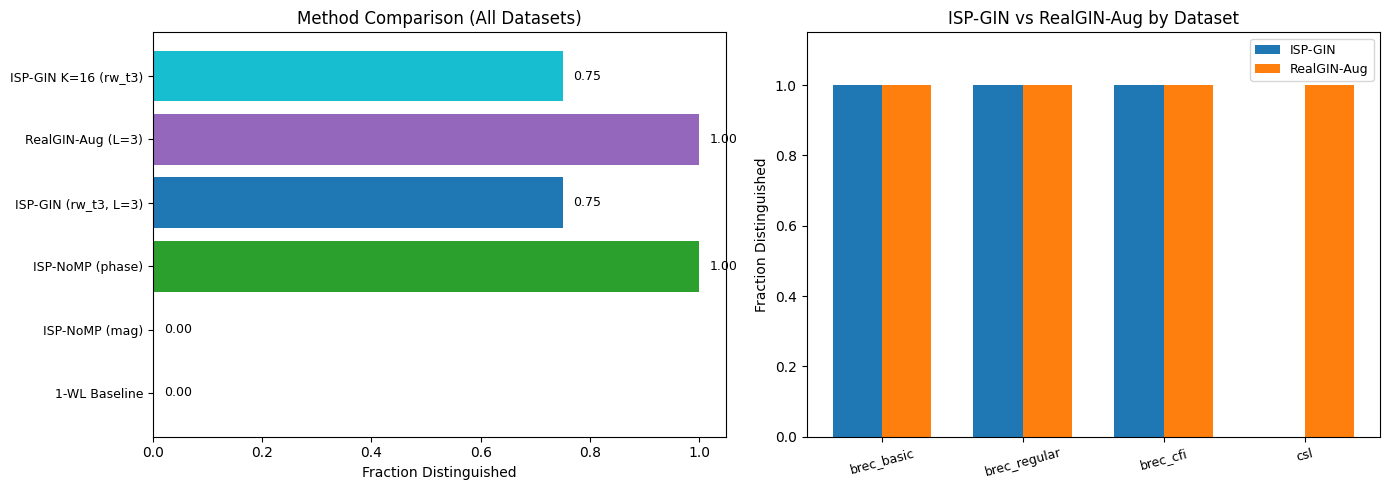

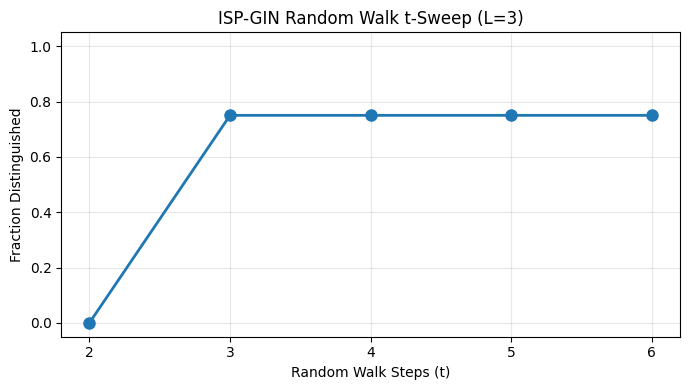


Experiment runtime: 0.5s


In [12]:
# --- Print results table ---
agg_results = output["metadata"]["aggregate_results"]

# Key methods to highlight (pick representative L=3 variants)
key_methods = [
    ("wl_baseline", "1-WL Baseline"),
    ("isp_nomp_mag_random_walk_t3", "ISP-NoMP (mag)"),
    ("isp_nomp_phase_random_walk_t3", "ISP-NoMP (phase)"),
    ("isp_gin_random_walk_t3_L3", "ISP-GIN (rw_t3, L=3)"),
    ("real_gin_aug_L3", "RealGIN-Aug (L=3)"),
    ("isp_gin_rw_t3_K16_L3", "ISP-GIN K=16 (rw_t3)"),
]

print("=" * 55)
print(f"{'Method':<30s} {'Dist':>6s} {'Total':>6s} {'Frac':>8s}")
print("=" * 55)
for method_key, label in key_methods:
    if method_key in agg_results:
        s = agg_results[method_key]
        print(f"{label:<30s} {s['distinguished']:>6d} {s['total']:>6d} {s['fraction']:>8.4f}")
print("=" * 55)

# --- Figure 1: Method comparison bar chart ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Overall method comparison
methods_plot = []
fracs_plot = []
for method_key, label in key_methods:
    if method_key in agg_results:
        methods_plot.append(label)
        fracs_plot.append(agg_results[method_key]["fraction"])

colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4', '#9467bd', '#17becf']
bars = axes[0].barh(range(len(methods_plot)), fracs_plot, color=colors[:len(methods_plot)])
axes[0].set_yticks(range(len(methods_plot)))
axes[0].set_yticklabels(methods_plot, fontsize=9)
axes[0].set_xlabel("Fraction Distinguished")
axes[0].set_title("Method Comparison (All Datasets)")
axes[0].set_xlim(0, 1.05)
for i, v in enumerate(fracs_plot):
    axes[0].text(v + 0.02, i, f"{v:.2f}", va='center', fontsize=9)

# Panel B: Per-dataset breakdown for key methods
ds_breakdown = output["metadata"]["per_dataset_breakdown"]
datasets = list(ds_breakdown.keys())
compare_methods = [
    ("isp_gin_random_walk_t3_L3", "ISP-GIN"),
    ("real_gin_aug_L3", "RealGIN-Aug"),
]

x = np.arange(len(datasets))
width = 0.35
for i, (mk, ml) in enumerate(compare_methods):
    vals = []
    for ds in datasets:
        if mk in ds_breakdown[ds]:
            parts = ds_breakdown[ds][mk].split("/")
            vals.append(int(parts[0]) / max(int(parts[1]), 1))
        else:
            vals.append(0.0)
    axes[1].bar(x + i * width - width/2, vals, width, label=ml)

axes[1].set_xticks(x)
axes[1].set_xticklabels(datasets, rotation=15, fontsize=9)
axes[1].set_ylabel("Fraction Distinguished")
axes[1].set_title("ISP-GIN vs RealGIN-Aug by Dataset")
axes[1].legend(fontsize=9)
axes[1].set_ylim(0, 1.15)

plt.tight_layout()
plt.savefig("results_plot.png", dpi=100, bbox_inches="tight")
plt.show()

# --- Figure 2: Random walk t-sweep ---
rw_data = output["metadata"]["rw_sweep"]
if rw_data:
    fig2, ax2 = plt.subplots(figsize=(7, 4))
    t_vals = []
    frac_vals = []
    for t_key, ratio_str in sorted(rw_data.items()):
        t_val = int(t_key.replace("t", ""))
        parts = ratio_str.split("/")
        frac = int(parts[0]) / max(int(parts[1]), 1)
        t_vals.append(t_val)
        frac_vals.append(frac)

    ax2.plot(t_vals, frac_vals, 'o-', color='#1f77b4', linewidth=2, markersize=8)
    ax2.set_xlabel("Random Walk Steps (t)")
    ax2.set_ylabel("Fraction Distinguished")
    ax2.set_title("ISP-GIN Random Walk t-Sweep (L=3)")
    ax2.set_ylim(-0.05, 1.05)
    ax2.set_xticks(t_vals)
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("rw_sweep_plot.png", dpi=100, bbox_inches="tight")
    plt.show()

print(f"\nExperiment runtime: {elapsed:.1f}s")